In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import logging
import galsim
import random
import cmath as cm
import math
import scipy
import scipy.stats as stats
from astropy.io import fits
from astropy.cosmology import WMAP9 as cosmo
%matplotlib inline
import tensorflow as tf
import seaborn as sns
from importlib import reload
import pandas as pd
import matplotlib
import matplotlib as mpl

In [2]:
sys.path.insert(0,'../../scripts/tools_for_VAE/')
import tools_for_VAE

from tools_for_VAE import vae_functions, model, plot, generator, results_processing, utils

from tools_for_VAE.model import build_encoder, build_decoder
from tools_for_VAE.utils import load_vae_conv, denorm, norm
from tools_for_VAE.plot import plot_rgb_lsst, plot_rgb_lsst_euclid, createCircularMask, mean_var, plot_corner_latent
from tools_for_VAE.results_processing import VAE_processing


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



# Loading the trained VAE

In [3]:
vae_lsst_r_band_conv, vae_r_utils, encoder_R, Dkl = load_vae_conv('/sps/lsst/users/barcelin/weights/R_band/VAE/noisy/v21/bis_bis/mse/',1, folder = True) # v21/bis_bis

Instructions for updating:
Colocations handled automatically by placer.


In [17]:
vae_lsst_conv,vae_lsst_utils, encoder_LSST, Dkl = load_vae_conv('/sps/lsst/users/barcelin/weights/LSST/VAE/noisy/v15/mse/',6, folder= True) # v12/bis2

In [4]:
vae_lsst_euclid_conv,vae_lsst_euclid_utils, encoder_LSST_EUCLID, Dkl = load_vae_conv('/sps/lsst/users/barcelin/weights/LSST_EUCLID/VAE/noisy/v12/mse/',10, folder = True)#v13/bis/ #v9/bis2

# Load data

In [3]:
data_dir = "/sps/lsst/users/barcelin/data/single_galaxies/test/"
root = 'galaxies_isolated_20191022_0'

In [4]:
images = np.load(data_dir+'galaxies_isolated_20191022_0_images.npy', mmap_mode = 'c')

In [5]:
dfs = []

dfs.append(pd.read_csv(os.path.join(data_dir, root+'_data.csv')))
df = dfs[0]

for df2 in dfs[1:]:
    df = df.append(df2)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
redshift        10000 non-null float64
moment_sigma    10000 non-null float64
e1              10000 non-null float64
e2              10000 non-null float64
SNR             10000 non-null float64
SNR_peak        10000 non-null float64
mag             10000 non-null float64
dtypes: float64(7)
memory usage: 547.0 KB


In [7]:
len(df)

10000

In [8]:
e1_sup = df['e1']>0.5
e1_inf = df['e1']<-0.5
e2_sup = df['e2']>0.5
e2_inf = df['e2']<-0.5

e1_X = e1_sup | e1_inf
e2_X = e2_sup | e2_inf

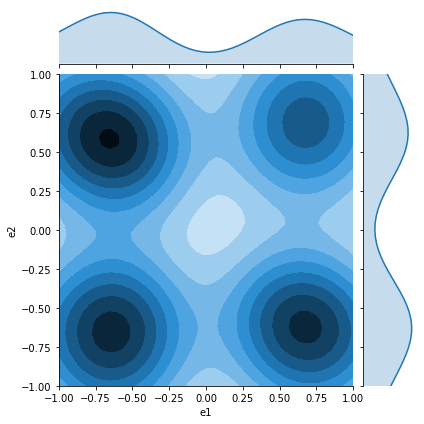

In [11]:
sns.jointplot(x="e1", y="e2", data=df[e1_X & e2_X], kind="kde", xlim = (-1,1), ylim = (-1,1))

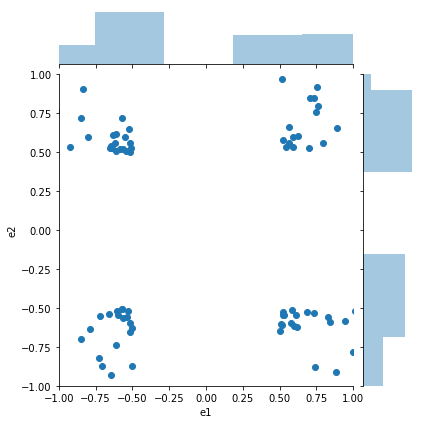

In [12]:
sns.jointplot(x="e1", y="e2", data=df[e1_X & e2_X], kind="scatter", xlim = (-1,1), ylim = (-1,1))

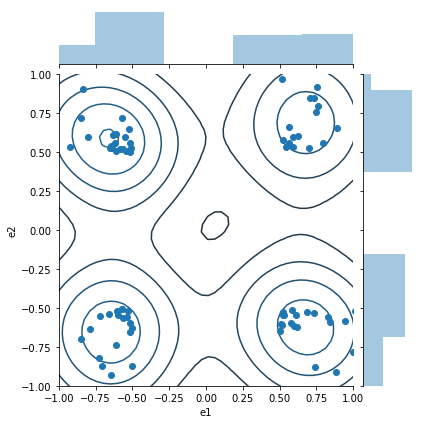

In [18]:
sns.jointplot(x="e1", y="e2", data=df[e1_X & e2_X], xlim = (-1,1), ylim = (-1,1)).plot_joint(sns.kdeplot, zorder=0, n_levels=6)

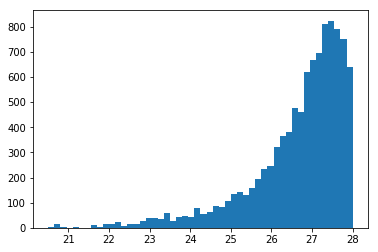

In [8]:
_ = plt.hist(df['SNR'], bins = 50)

In [9]:
list_of_samples=[data_dir+'galaxies_isolated_20191022_0_images.npy']

# Generators

In [10]:
bands_r = [6]

In [11]:
batch_gen_r = generator.BatchGenerator(bands_r, list_of_samples, total_sample_size=len(list_of_samples[0]),
                               batch_size= 100, trainval_or_test = 'test',
                               do_norm = True, denorm = False, list_of_weights_e = None)

[BatchGenerator] total_sample_size =  10000
[BatchGenerator] len(list_of_samples) =  1


In [12]:
bands_lsst = [4,5,6,7,8,9]

In [13]:
batch_gen_lsst = generator.BatchGenerator(bands_lsst, list_of_samples,total_sample_size=len(list_of_samples[0]),
                                batch_size= 100, trainval_or_test = 'test',
                                do_norm = True, denorm = False, list_of_weights_e = None)

[BatchGenerator] total_sample_size =  10000
[BatchGenerator] len(list_of_samples) =  1


In [14]:
bands_lsst_euclid = [0,1,2,3,4,5,6,7,8,9]

In [15]:
batch_gen_lsst_euclid = generator.BatchGenerator(bands_lsst_euclid, list_of_samples,total_sample_size=len(list_of_samples[0]), 
                                       batch_size= 100,  trainval_or_test = 'test', 
                                       do_norm = True, denorm =False,list_of_weights_e = None)

[BatchGenerator] total_sample_size =  10000
[BatchGenerator] len(list_of_samples) =  1


# Parameters to fix

In [18]:
phys_stamp_size = 6.4 # arcsec
pixel_scale_euclid_vis = 0.1 # arcsec/pixel

stamp_size = int(phys_stamp_size/pixel_scale_euclid_vis)

# VAE LSST R band

Test of data processing functions

In [142]:
reload(results_processing)

<module 'tools_for_VAE.results_processing' from '../../scripts/tools_for_VAE/tools_for_VAE/results_processing.py'>

In [65]:
pix_scale_lsst = 0.2
PSF = galsim.Kolmogorov(fwhm=0.65)

In [74]:
N = 100
batch_size = 100

ellipticities_r_band, e_beta_r, flux_in_r, flux_out_r, indices_r = results_processing.VAE_processing(vae_lsst_r_band_conv, 
                                                                                                              batch_gen_r,
                                                                                                              bands_r,
                                                                                                              0,
                                                                                                              stamp_size, 
                                                                                                              N, 
                                                                                                              batch_size, 
                                                                                                              PSF, 
                                                                                                              pix_scale_lsst)

In [36]:
np.save('data/vae_r_e1_e2.npy', ellipticities_r_band)
np.save('data/vae_r_e_beta.npy', e_beta_r)
np.save('data/vae_r_flux_in.npy', flux_in_r)
np.save('data/vae_r_flux_out.npy', flux_out_r)
np.save('data/vae_r_indices.npy', indices_r)

In [34]:
ellipticities_r_band = np.load('data/vae_r_e1_e2.npy')
e_beta_r = np.load('data/vae_r_e_beta.npy')
flux_in_r = np.load('data/vae_r_flux_in.npy')
flux_out_r = np.load('data/vae_r_flux_out.npy')
indices_r = np.load('data/vae_r_indices.npy')

In [35]:
print(ellipticities_r_band[:,1,1])

[ 0.28586873  0.05325546 -0.01208825 ... -0.23311707  0.42779398
  0.09107356]


In [36]:
delta_e_r = e_beta_r[:,1,0]- e_beta_r[:,0,0]
delta_e1_r = ellipticities_r_band[:,1,0]- ellipticities_r_band[:,0,0]
delta_e2_r = ellipticities_r_band[:,1,1]- ellipticities_r_band[:,0,1]

In [37]:
delta_mag_r = -2.5*np.log10(flux_out_r/flux_in_r)

## Shape plots

In [78]:
df_plot = {}

df_plot['e1_in'] = ellipticities_r_band[:,0,0]
df_plot['e1_out'] = ellipticities_r_band[:,1,0]

df_plot['e2_in'] = ellipticities_r_band[:,0,1]
df_plot['e2_out'] = ellipticities_r_band[:,1,1]

df_plot['e_in'] = e_beta_r[:,0,0]
df_plot['e_out'] = e_beta_r[:,1,0]

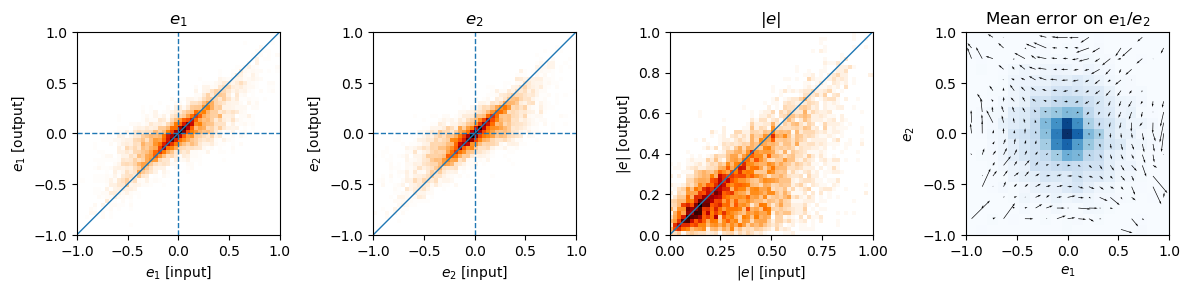

In [79]:
import scipy
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(12,5))

# Cut in SNR
#df_plot = df[df['SNR_peak']>5.]

emax = 1
bins = np.linspace(-emax,+emax,51)

ax = fig.add_subplot(141, aspect='equal')
_ = ax.hist2d(df_plot['e1_in'], df_plot['e1_out'], bins=bins, cmap=mpl.cm.gist_heat_r)
ax.plot([-emax,+emax],[-emax,+emax], lw=1)
ax.axhline(y=0, ls='--', lw=1)
ax.axvline(x=0, ls='--', lw=1)
ax.set_xlabel('$e_1$ [input]')
ax.set_ylabel('$e_1$ [output]')
ax.set_title('$e_1$')

ax = fig.add_subplot(142, aspect='equal')
_ = ax.hist2d(df_plot['e2_in'], df_plot['e2_out'], bins=bins, cmap=mpl.cm.gist_heat_r)
ax.plot([-emax,+emax],[-emax,+emax], lw=1)
ax.axhline(y=0, ls='--', lw=1)
ax.axvline(x=0, ls='--', lw=1)
ax.set_xlabel('$e_2$ [input]')
ax.set_ylabel('$e_2$ [output]')
ax.set_title('$e_2$')

ax = fig.add_subplot(143, aspect='equal')
_ = ax.hist2d(np.sqrt(df_plot['e1_in']**2+df_plot['e2_in']**2), np.sqrt(df_plot['e1_out']**2+df_plot['e2_out']**2), bins=np.linspace(0,1,51), cmap=mpl.cm.gist_heat_r)
#_ = ax.hist2d(df_plot['e_in'],df_plot['e_out'], bins=np.linspace(0,1,51), cmap=mpl.cm.gist_heat_r)
ax.plot([0,1],[0,1], lw=1)
ax.set_xlabel('$|e|$ [input]')
ax.set_ylabel('$|e|$ [output]')
ax.set_title('$|e|$')


ax = fig.add_subplot(144, aspect='equal')

bins = np.linspace(-emax,emax,20)
e1_in_m = scipy.stats.binned_statistic_2d(df_plot['e1_in'], df_plot['e2_in'], values=df_plot['e1_in'], bins=bins, statistic='mean').statistic
e2_in_m = scipy.stats.binned_statistic_2d(df_plot['e1_in'], df_plot['e2_in'], values=df_plot['e2_in'], bins=bins, statistic='mean').statistic
e1_out_m = scipy.stats.binned_statistic_2d(df_plot['e1_in'], df_plot['e2_in'], values=df_plot['e1_out'], bins=bins, statistic='mean').statistic
e2_out_m = scipy.stats.binned_statistic_2d(df_plot['e1_in'], df_plot['e2_in'], values=df_plot['e2_out'], bins=bins, statistic='mean').statistic

im = ax.hist2d(df_plot['e1_in'], df_plot['e2_in'], bins=bins, cmap=mpl.cm.Blues)[-1]

bins_mid = 0.5*(bins[1:]+bins[:-1])
X,Y = np.meshgrid(bins_mid, bins_mid)
ax.quiver(X,Y,e1_out_m-e1_in_m, e2_out_m-e2_in_m)

ax.set_xlabel('$e_1$')
ax.set_ylabel('$e_2$')
ax.set_xlim(bins[0],bins[-1])
ax.set_ylim(bins[0],bins[-1])

ax.set_title('Mean error on $e_1/e_2$')

plt.tight_layout()

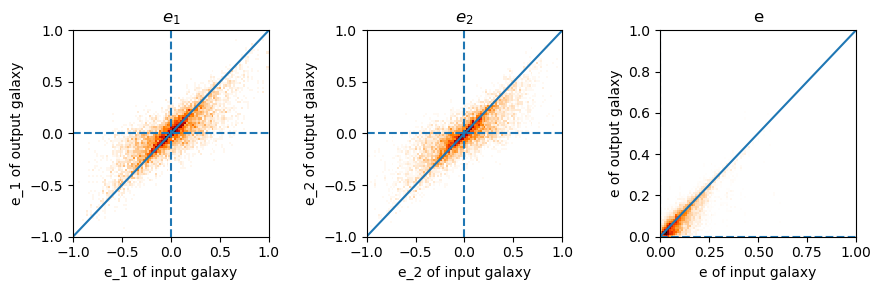

In [80]:
import matplotlib as mpl

fig, axes = plt.subplots(1,3, figsize=(9,3))
emax = 1
for i in range(2):
    _ = axes[i].hist2d(ellipticities_r_band[:,0,i], ellipticities_r_band[:,1,i], bins=np.linspace(-emax,+emax,101), cmap=mpl.cm.gist_heat_r)
    axes[i].plot([-emax,+emax],[-emax,+emax])
    axes[i].axhline(y=0, ls='--')
    axes[i].axvline(x=0, ls='--')
    axes[i].set_title('$e_{}$'.format(i+1))# color="w", 
    axes[i].spines['bottom']#.set_color('w')
    axes[i].spines['right']#.set_color('w')
    axes[i].spines['left']#.set_color('w')
    axes[i].spines['top']#.set_color('w')
    axes[i].xaxis.label#.set_color('w')
    axes[i].tick_params(axis='x')#, colors='w'
    axes[i].tick_params(axis='y')#, colors='w'
    axes[i].set_xlabel('e_'+str(i+1)+' of input galaxy')
    axes[i].set_ylabel('e_'+str(i+1)+' of output galaxy')

_ = axes[2].hist2d(e_beta_r[:,0,0], e_beta_r[:,1,0], bins=np.linspace(0,+emax,101), cmap=mpl.cm.gist_heat_r)
axes[2].plot([0,+emax],[0,+emax])
axes[2].axhline(y=0, ls='--')
axes[2].axvline(x=0, ls='--')
axes[2].set_title('e'.format(i+1))# color="w", 
axes[2].tick_params(axis='x')#, colors='w'
axes[2].tick_params(axis='y')#, colors='w'
axes[2].set_xlabel('e of input galaxy')
axes[2].set_ylabel('e of output galaxy')

plt.tight_layout()

## LSST all filters

In [19]:
pix_scale_lsst = 0.2
PSF = galsim.Kolmogorov(fwhm=0.65)

In [20]:
N = 100
batch_size = 100

ellipticities_lsst, e_beta_lsst, flux_in_lsst, flux_out_lsst, indices_lsst = results_processing.VAE_processing(vae_lsst_conv, 
                                                                                          batch_gen_lsst,
                                                                                          bands_lsst,
                                                                                          2,
                                                                                          stamp_size, 
                                                                                          N, 
                                                                                          batch_size,
                                                                                          PSF, 
                                                                                          pix_scale_lsst)

In [49]:
np.save('data/vae_lsst_e1_e2.npy', ellipticities_lsst)
np.save('data/vae_lsst_e_beta.npy', e_beta_lsst)
np.save('data/vae_lsst_flux_in.npy', flux_in_lsst)
np.save('data/vae_lsst_flux_out.npy', flux_out_lsst)
np.save('data/vae_lsst_indices.npy', indices_lsst)

In [50]:
ellipticities_lsst = np.load('data/vae_lsst_e1_e2.npy')
e_beta_lsst = np.load('data/vae_lsst_e_beta.npy')
flux_in_lsst = np.load('data/vae_lsst_flux_in.npy')
flux_out_lsst = np.load('data/vae_lsst_flux_out.npy')
indices_lsst = np.load('data/vae_lsst_indices.npy')

In [21]:
delta_e_lsst = e_beta_lsst[:,1,0]- e_beta_lsst[:,0,0]
delta_e1_lsst = ellipticities_lsst[:,1,0]- ellipticities_lsst[:,0,0]
delta_e2_lsst = ellipticities_lsst[:,1,1]- ellipticities_lsst[:,0,1]

In [22]:
delta_mag_lsst = -2.5*np.log10(flux_out_lsst/flux_in_lsst)

### Shape plots

In [23]:
df_plot = {}

df_plot['e1_in'] = ellipticities_lsst[:,0,0]
df_plot['e1_out'] = ellipticities_lsst[:,1,0]

df_plot['e2_in'] = ellipticities_lsst[:,0,1]
df_plot['e2_out'] = ellipticities_lsst[:,1,1]

df_plot['e_in'] = e_beta_lsst[:,0,0]
df_plot['e_out'] = e_beta_lsst[:,1,0]

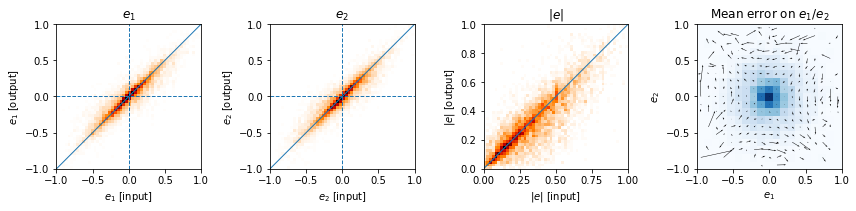

In [24]:
import scipy
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(12,5))

# Cut in SNR
#df_plot = df[df['SNR_peak']>5.]

emax = 1
bins = np.linspace(-emax,+emax,51)

ax = fig.add_subplot(141, aspect='equal')
_ = ax.hist2d(df_plot['e1_in'], df_plot['e1_out'], bins=bins, cmap=mpl.cm.gist_heat_r)
ax.plot([-emax,+emax],[-emax,+emax], lw=1)
ax.axhline(y=0, ls='--', lw=1)
ax.axvline(x=0, ls='--', lw=1)
ax.set_xlabel('$e_1$ [input]')
ax.set_ylabel('$e_1$ [output]')
ax.set_title('$e_1$')

ax = fig.add_subplot(142, aspect='equal')
_ = ax.hist2d(df_plot['e2_in'], df_plot['e2_out'], bins=bins, cmap=mpl.cm.gist_heat_r)
ax.plot([-emax,+emax],[-emax,+emax], lw=1)
ax.axhline(y=0, ls='--', lw=1)
ax.axvline(x=0, ls='--', lw=1)
ax.set_xlabel('$e_2$ [input]')
ax.set_ylabel('$e_2$ [output]')
ax.set_title('$e_2$')

ax = fig.add_subplot(143, aspect='equal')
_ = ax.hist2d(np.sqrt(df_plot['e1_in']**2+df_plot['e2_in']**2), np.sqrt(df_plot['e1_out']**2+df_plot['e2_out']**2), bins=np.linspace(0,1,51), cmap=mpl.cm.gist_heat_r)
#_ = ax.hist2d(df_plot['e_in'],df_plot['e_out'], bins=np.linspace(0,1,51), cmap=mpl.cm.gist_heat_r)
ax.plot([0,1],[0,1], lw=1)
ax.set_xlabel('$|e|$ [input]')
ax.set_ylabel('$|e|$ [output]')
ax.set_title('$|e|$')


ax = fig.add_subplot(144, aspect='equal')

bins = np.linspace(-emax,emax,20)
e1_in_m = scipy.stats.binned_statistic_2d(df_plot['e1_in'], df_plot['e2_in'], values=df_plot['e1_in'], bins=bins, statistic='mean').statistic
e2_in_m = scipy.stats.binned_statistic_2d(df_plot['e1_in'], df_plot['e2_in'], values=df_plot['e2_in'], bins=bins, statistic='mean').statistic
e1_out_m = scipy.stats.binned_statistic_2d(df_plot['e1_in'], df_plot['e2_in'], values=df_plot['e1_out'], bins=bins, statistic='mean').statistic
e2_out_m = scipy.stats.binned_statistic_2d(df_plot['e1_in'], df_plot['e2_in'], values=df_plot['e2_out'], bins=bins, statistic='mean').statistic

im = ax.hist2d(df_plot['e1_in'], df_plot['e2_in'], bins=bins, cmap=mpl.cm.Blues)[-1]

bins_mid = 0.5*(bins[1:]+bins[:-1])
X,Y = np.meshgrid(bins_mid, bins_mid)
ax.quiver(X,Y,e1_out_m-e1_in_m, e2_out_m-e2_in_m)

ax.set_xlabel('$e_1$')
ax.set_ylabel('$e_2$')
ax.set_xlim(bins[0],bins[-1])
ax.set_ylim(bins[0],bins[-1])

ax.set_title('Mean error on $e_1/e_2$')

plt.tight_layout()
plt.savefig('figures/ellipticities_lsst.pdf', dpi = 300)

Text(0, 0.5, 'e of output galaxy')

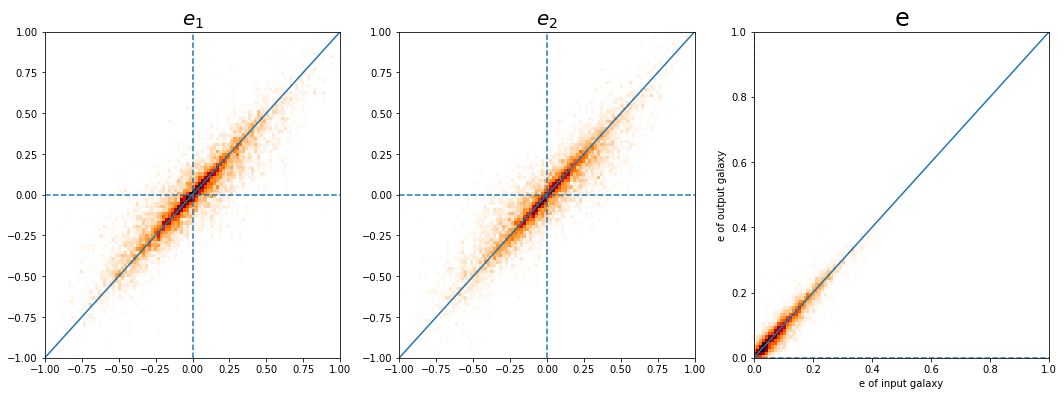

In [25]:
import matplotlib as mpl

fig, axes = plt.subplots(1,3, figsize=(18,6))
emax = 1
for i in range(2):
    _ = axes[i].hist2d(ellipticities_lsst[:,0,i], ellipticities_lsst[:,1,i], bins=np.linspace(-emax,+emax,101), cmap=mpl.cm.gist_heat_r)
    axes[i].plot([-emax,+emax],[-emax,+emax])
    axes[i].axhline(y=0, ls='--')
    axes[i].axvline(x=0, ls='--')
    axes[i].set_title('$e_{}$'.format(i+1), fontsize=20)
    axes[i].spines['bottom']#.set_color('w')
    axes[i].spines['right']#.set_color('w')
    axes[i].spines['left']#.set_color('w')
    axes[i].spines['top']#.set_color('w')
    axes[i].xaxis.label#.set_color('w')
    axes[i].tick_params(axis='x')
    axes[i].tick_params(axis='y')
    
_ = axes[2].hist2d(e_beta_lsst[:,0,0], e_beta_lsst[:,1,0], bins=np.linspace(0,+emax,101), cmap=mpl.cm.gist_heat_r)
axes[2].plot([0,+emax],[0,+emax])
axes[2].axhline(y=0, ls='--')
axes[2].axvline(x=0, ls='--')
axes[2].set_title('e'.format(i+1),fontsize=24)# color="w", 
#plt.xaxis.label#.set_color('w')
axes[2].tick_params(axis='x')#, colors='w'
axes[2].tick_params(axis='y')#, colors='w'
axes[2].set_xlabel('e of input galaxy')
axes[2].set_ylabel('e of output galaxy')

## LSST + Euclid all filters

Test VAE_processing for LSST and Euclid all band-pass filters

In [48]:
reload(results_processing)

<module 'tools_for_VAE.results_processing' from '../../scripts/tools_for_VAE/tools_for_VAE/results_processing.py'>

In [19]:
pix_scale_lsst = 0.2
PSF = galsim.Kolmogorov(fwhm=0.65)

In [20]:
N = 100
batch_size = 100

ellipticities_lsst_euclid, e_beta_lsst_euclid, flux_in_lsst_euclid, flux_out_lsst_euclid, indices_lsst_euclid = results_processing.VAE_processing(vae_lsst_euclid_conv, 
                                                                                                                               batch_gen_lsst_euclid,
                                                                                                                               bands_lsst_euclid,
                                                                                                                               6,
                                                                                                                               stamp_size, 
                                                                                                                               N, 
                                                                                                                               batch_size,
                                                                                                                               PSF, 
                                                                                                                               pix_scale_lsst)

In [41]:
np.save('data/vae_lsst_euclid_e1_e2.npy', ellipticities_lsst_euclid)
np.save('data/vae_lsst_euclid_e_beta.npy', e_beta_lsst_euclid)
np.save('data/vae_lsst_euclid_flux_in.npy', flux_in_lsst_euclid)
np.save('data/vae_lsst_euclid_flux_out.npy', flux_in_lsst_euclid)
np.save('data/vae_lsst_euclid_indices.npy', indices_lsst_euclid) # 2599, 4451 # 2935, 5557 # 61, 7955, 8216

In [42]:
ellipticities_lsst_euclid = np.load('data/vae_lsst_euclid_e1_e2.npy')
e_beta_lsst_euclid = np.load('data/vae_lsst_euclid_e_beta.npy')
flux_in_lsst_euclid = np.load('data/vae_lsst_euclid_flux_in.npy')
flux_out_lsst_euclid = np.load('data/vae_lsst_euclid_flux_out.npy')
indices_lsst_euclid = np.load('data/vae_lsst_euclid_indices.npy')

In [21]:
delta_e_lsst_euclid = e_beta_lsst_euclid[:,1,0]- e_beta_lsst_euclid[:,0,0]
delta_e1_lsst_euclid = ellipticities_lsst_euclid[:,1,0]- ellipticities_lsst_euclid[:,0,0]
delta_e2_lsst_euclid = ellipticities_lsst_euclid[:,1,1]- ellipticities_lsst_euclid[:,0,1]

In [22]:
delta_mag_lsst_euclid = -2.5*np.log10(flux_out_lsst_euclid/flux_in_lsst_euclid)

In [23]:
print(delta_mag_lsst_euclid)

[-0.00550875  0.08181829  0.03940224 ...  0.01677964  0.06085474
 -0.05072846]


### Shape plots

In [24]:
df_plot = {}

df_plot['e1_in'] = ellipticities_lsst_euclid[:,0,0]
df_plot['e1_out'] = ellipticities_lsst_euclid[:,1,0]

df_plot['e2_in'] = ellipticities_lsst_euclid[:,0,1]
df_plot['e2_out'] = ellipticities_lsst_euclid[:,1,1]

df_plot['e_in'] = e_beta_lsst_euclid[:,0,0]
df_plot['e_out'] = e_beta_lsst_euclid[:,1,0]

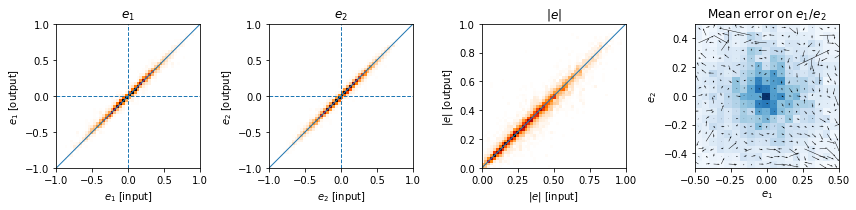

In [25]:
import scipy
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(12,5))

# Cut in SNR
#df_plot = df[df['SNR_peak']>5.]

emax = 1
bins = np.linspace(-emax,+emax,51)

ax = fig.add_subplot(141, aspect='equal')
_ = ax.hist2d(df_plot['e1_in'], df_plot['e1_out'], bins=bins, cmap=mpl.cm.gist_heat_r)
ax.plot([-emax,+emax],[-emax,+emax], lw=1)
ax.axhline(y=0, ls='--', lw=1)
ax.axvline(x=0, ls='--', lw=1)
ax.set_xlabel('$e_1$ [input]')
ax.set_ylabel('$e_1$ [output]')
ax.set_title('$e_1$')

ax = fig.add_subplot(142, aspect='equal')
_ = ax.hist2d(df_plot['e2_in'], df_plot['e2_out'], bins=bins, cmap=mpl.cm.gist_heat_r)
ax.plot([-emax,+emax],[-emax,+emax], lw=1)
ax.axhline(y=0, ls='--', lw=1)
ax.axvline(x=0, ls='--', lw=1)
ax.set_xlabel('$e_2$ [input]')
ax.set_ylabel('$e_2$ [output]')
ax.set_title('$e_2$')

ax = fig.add_subplot(143, aspect='equal')
_ = ax.hist2d(np.sqrt(df_plot['e1_in']**2+df_plot['e2_in']**2), np.sqrt(df_plot['e1_out']**2+df_plot['e2_out']**2), bins=np.linspace(0,1,51), cmap=mpl.cm.gist_heat_r)
#_ = ax.hist2d(df_plot['e_in'],df_plot['e_out'], bins=np.linspace(0,1,51), cmap=mpl.cm.gist_heat_r)
ax.plot([0,1],[0,1], lw=1)
ax.set_xlabel('$|e|$ [input]')
ax.set_ylabel('$|e|$ [output]')
ax.set_title('$|e|$')

emax = 0.5
ax = fig.add_subplot(144, aspect='equal')

bins = np.linspace(-emax,emax,20)
e1_in_m = scipy.stats.binned_statistic_2d(df_plot['e1_in'], df_plot['e2_in'], values=df_plot['e1_in'], bins=bins, statistic='mean').statistic
e2_in_m = scipy.stats.binned_statistic_2d(df_plot['e1_in'], df_plot['e2_in'], values=df_plot['e2_in'], bins=bins, statistic='mean').statistic
e1_out_m = scipy.stats.binned_statistic_2d(df_plot['e1_in'], df_plot['e2_in'], values=df_plot['e1_out'], bins=bins, statistic='mean').statistic
e2_out_m = scipy.stats.binned_statistic_2d(df_plot['e1_in'], df_plot['e2_in'], values=df_plot['e2_out'], bins=bins, statistic='mean').statistic

im = ax.hist2d(df_plot['e1_in'], df_plot['e2_in'], bins=bins, cmap=mpl.cm.Blues)[-1]

bins_mid = 0.5*(bins[1:]+bins[:-1])
X,Y = np.meshgrid(bins_mid, bins_mid)
ax.quiver(X,Y,e1_out_m-e1_in_m, e2_out_m-e2_in_m)

ax.set_xlabel('$e_1$')
ax.set_ylabel('$e_2$')
ax.set_xlim(bins[0],bins[-1])
ax.set_ylim(bins[0],bins[-1])

ax.set_title('Mean error on $e_1/e_2$')

plt.tight_layout()

Text(0, 0.5, 'e of output galaxy')

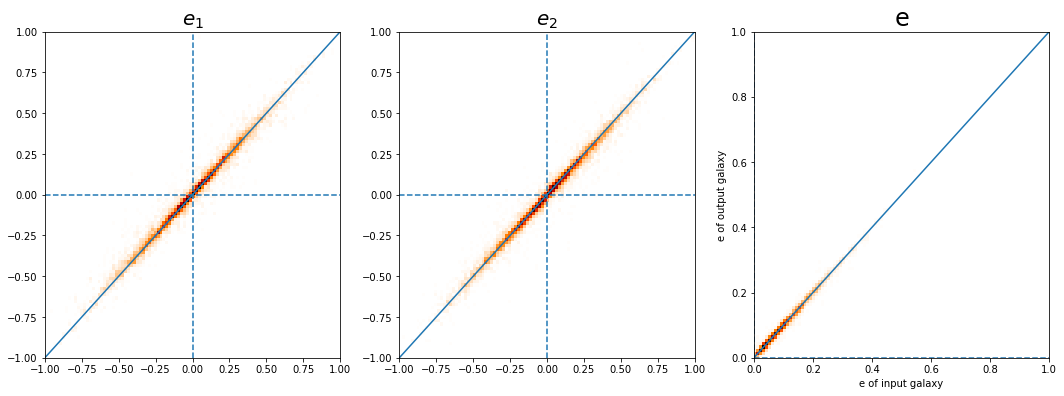

In [26]:
import matplotlib as mpl

fig, axes = plt.subplots(1,3, figsize=(18,6))
emax = 1
for i in range(2):
    _ = axes[i].hist2d(ellipticities_lsst_euclid[:,0,i], ellipticities_lsst_euclid[:,1,i], bins=np.linspace(-emax,+emax,101), cmap=mpl.cm.gist_heat_r)
    axes[i].plot([-emax,+emax],[-emax,+emax])
    axes[i].axhline(y=0, ls='--')
    axes[i].axvline(x=0, ls='--')
    axes[i].set_title('$e_{}$'.format(i+1), fontsize=20)#, color="w"
    axes[i].spines['bottom']#.set_color('w')
    axes[i].spines['right']#.set_color('w')
    axes[i].spines['left']#.set_color('w')
    axes[i].spines['top']#.set_color('w')
    axes[i].xaxis.label#.set_color('w')
    axes[i].tick_params(axis='x')#, colors='w')
    axes[i].tick_params(axis='y')#, colors='w')
    

_ = axes[2].hist2d(e_beta_lsst_euclid[:,0,0], e_beta_lsst_euclid[:,1,0], bins=np.linspace(0,+emax,101), cmap=mpl.cm.gist_heat_r)
axes[2].plot([0,+emax],[0,+emax])
axes[2].axhline(y=0, ls='--')
axes[2].axvline(x=0, ls='--')
axes[2].set_title('e'.format(i+1),fontsize=24)# color="w", 
axes[2].tick_params(axis='x')#, colors='w'
axes[2].tick_params(axis='y')#, colors='w'
axes[2].set_xlabel('e of input galaxy')
axes[2].set_ylabel('e of output galaxy')

# Delta WL parameters

## As function of SNR

In [38]:
def boxplot(v,p,
            indices, 
            xlim, ylim, 
            x_scale,
            legend,
            x_label, y_label,
            errors,
            legend_remove = False,
            palette = ["#5EC6C5","#3498db","#e74c3c"],
            nbins = 11):
    matplotlib.rcdefaults()
    
    params = []
    for i in range (len(v)):
        params.append(np.array(df[p][indices[i]]))
        
    params_new = []
    for i in range (len(v)):
        params[i] = np.delete(params[i], errors[i])
        p_is_nan = np.where(np.isnan(params[i]))[0]
        v[i] = np.delete(v[i], p_is_nan)
        params_new.append(np.delete(np.array(params[i]), p_is_nan))
    
    params_new = np.array(params_new)
    
    p_is_nan = np.where(np.isnan(df[p]))[0]
    new_p = np.delete(np.array(df[p]), p_is_nan)
    new_p = np.delete(new_p, np.random.choice(len(new_p), size =  len(np.concatenate(errors, axis = 0))))
    
    if x_scale == 'log':
        bins = np.geomspace(xlim[0], xlim[1], nbins)
    else :
        bins = np.linspace(xlim[0], xlim[1], nbins)
    
    bins[0] -= 1e-5
    bins[-1] += 1e-5
    
    param_bins = np.digitize(np.concatenate(params_new, axis = 0), bins)
    
    print(len(v[0]), len(v[1]), len(v[2]))
    v_conc = np.concatenate(v, axis = 0)
    
    exp = []
    for i in range (len(v)):
        exp.append([legend[i]]*len(params_new[i]))
    
    exp = np.concatenate(exp, axis = 0)
    
    d = {'param':param_bins,'v_error':v_conc, 'exp':exp}

    fig, axes = plt.subplots(2,1, figsize=(4,3), gridspec_kw={'height_ratios': [1, 3]})
    fig.tight_layout()
    fig.subplots_adjust(right=1, left=0,hspace=0,wspace=1)
    
    if x_scale == 'log':
        sns.distplot(np.log10(new_p), ax = axes[0], hist = False, color = 'grey')
        axes[0].set_xlim(np.log10(bins[0]), np.log10(bins[-1]))
    else :
        sns.distplot(new_p, ax = axes[0], hist = False, color = 'grey')
        axes[0].set_xlim(bins[0], bins[-1])
    
    axes[0].set_yticks([])
    axes[0].set_xticks([])  
    axes[0].spines['right'].set_color('none')
    axes[0].spines['top'].set_color('none')
    axes[0].spines['left'].set_color('none')


    pal = palette
    print(len(v_conc), len(param_bins), len(exp))
    axes[1] = sns.boxplot(x="param", y="v_error",hue='exp', data=d, fliersize = 0., palette = sns.color_palette(pal))
    axes[1].axhline(0, c ='0.8', ls = '-', lw=1, zorder = -3)

    axes[1].set_ylabel(y_label)
    axes[1].set_xticks([])
    axes[1].legend(fontsize = 9, frameon = False, loc ='lower right', borderpad = 0.1)
    if legend_remove :
        axes[1].legend_.remove()
    axes[1].set_ylim(ylim)

    ax = axes[1].twiny()
    ax.set_xlim(bins[0], bins[-1])
    if x_scale == 'log':
        ax.set_xscale('log')
    ax.xaxis.tick_bottom()
    ax.set_xlabel(x_label)
    ax.xaxis.set_label_position('bottom')
    
    return fig

In [39]:
np.min(df['SNR_peak'])

4.730731223118252

10000 10000 10000
30000 30000 30000


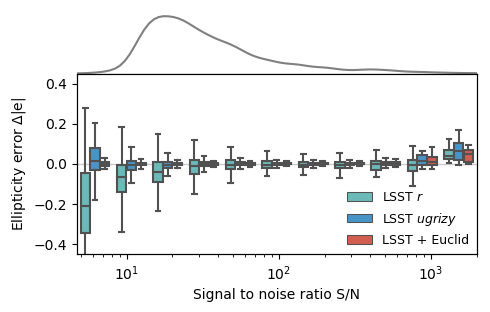

In [41]:
fig = boxplot([delta_e_r, delta_e_lsst, delta_e_lsst_euclid],
         'SNR_peak',
         indices = [indices_r,indices_lsst, indices_lsst_euclid],
         legend = ['LSST $r$', 'LSST $ugrizy$', 'LSST + Euclid'],
         xlim = (4.7, 2000),ylim = (-0.45, 0.45), x_scale = 'log',
         x_label='Signal to noise ratio S/N', y_label = 'Ellipticity error $\Delta$|e|',
         errors = [[], [], []],
         legend_remove = False )

fig.savefig('figures/vae_deltaE_SNR.pdf', dpi = 300)

10000 10000 10000
30000 30000 30000


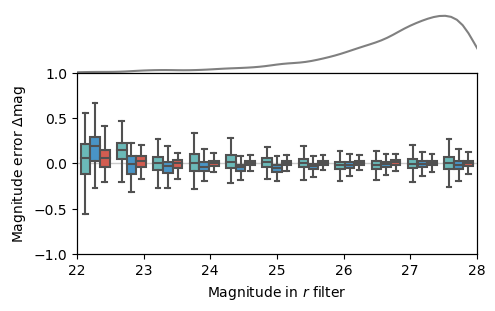

In [43]:
fig = boxplot([delta_mag_r, delta_mag_lsst, delta_mag_lsst_euclid],
         'SNR',
         indices = [indices_r,indices_lsst, indices_lsst_euclid],
         legend = ['LSST $r$', 'LSST $ugrizy$', 'LSST + Euclid'],
         xlim = (22, 28),ylim = (-1., 1.), x_scale = None,
         x_label='Magnitude in $r$ filter', y_label = 'Magnitude error $\Delta$mag',
         errors = [[], [], []],
         legend_remove = True )

fig.savefig('figures/vae_deltaMag_mag.pdf', dpi = 300)